# Caffe学习系列：模型各层数据和参数可视化

先用caffe对cifar10进行训练，将训练的结果模型进行保存，得到一个caffemodel，然后从测试图片中选出一张进行测试，并进行可视化。

In [1]:
# 加载必要的库
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import sys, os, caffe

In [2]:
# 设置当前目录，判断模型是否训练好
caffe_root = '/root/Repository/caffe/'
sys.path.insert(0, caffe_root + 'python')
os.chdir(caffe_root)
if not os.path.isfile(caffe_root + 'examples/cifar10/cifar10_quick_iter_4000.caffemodel'):
    print("caffemodel is not exist...")

In [3]:
# 利用提前训练好的模型，设置测试网络
net = caffe.Net(caffe_root + 'examples/cifar10/cifar10_quick.prototxt',
                caffe_root + 'examples/cifar10/cifar10_quick_iter_4000.caffemodel',
                caffe.TEST)

In [4]:
net.blobs['data'].data.shape

(1, 3, 32, 32)

(323, 481, 3)


(-0.5, 480.5, 322.5, -0.5)

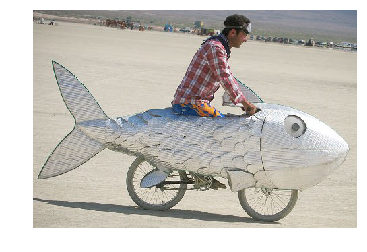

In [6]:
# 加载测试图片，并显示
im = caffe.io.load_image('examples/images/fish-bike.jpg')
print(im.shape)
plt.imshow(im)
plt.axis('off')

In [17]:
# 编写一个函数，将二进制的均值转换为python的均值
def convert_mean(binMean, npyMean):
    blob = caffe.proto.caffe_pb2.BlobProto()
    bin_mean = open(binMean, 'rb').read()
    blob.ParseFromString(bin_mean)
    arr = np.array(caffe.io.blobproto_to_array(blob))
    npy_mean = arr[0]
    np.save(npyMean, npy_mean)
binMean = caffe_root + 'examples/cifar10/mean.binaryproto'
npyMean = caffe_root + 'examples/cifar10/mean.npy'
convert_mean(binMean, npyMean)

AssertionError: 

In [ ]:
# 将图片载入blob中,并减去均值
transformer = caffe.io.Transformer({'data': net.blobs['data'].data.shape})
transformer.set_transpose('data', (2, 0, 1))
transformer.set_mean('data', np.load(npyMean).mean(1).mean(1)) # 减去均值
transformer.set_raw_scale('data', 255)  
transformer.set_channel_swap('data', (2, 1, 0))
net.blobs['data'].data[...] = transformer.preprocess('data', im)
inputData = net.blobs['data'].data

In [ ]:
# 显示减去均值前后的数据
plt.figure()
plt.subplot(1, 2, 1),plt.title("origin")
plt.imshow(im)
plt.axis('off')
plt.subplot(1, 2, 2),plt.title("subtract mean")
plt.imshow(transformer.deprocess('data', inputData[0]))
plt.axis('off')

In [ ]:
# 运行测试模型，并显示各层数据信息
net.forward()
[(k, v.data.shape) for k, v in net.blobs.items()]

In [ ]:
# 显示各层的参数信息
[(k, v[0].data.shape) for k, v in net.params.items()]

In [ ]:
#　编写一个函数，用于显示各层数据
def show_data(data, padsize=1, padval=0):
    data -= data.min()
    data /= data.max()
    
    # force the number of filters to be square
    n = int(np.ceil(np.sqrt(data.shape[0])))
    padding = ((0, n ** 2 - data.shape[0]), (0, padsize), (0, padsize)) + ((0, 0),) * (data.ndim - 3)
    data = np.pad(data, padding, mode='constant', constant_values=(padval, padval))
    
    # tile the filters into an image
    data = data.reshape((n, n) + data.shape[1:]).transpose((0, 2, 1, 3) + tuple(range(4, data.ndim + 1)))
    data = data.reshape((n * data.shape[1], n * data.shape[3]) + data.shape[4:])
    plt.figure()
    plt.imshow(data,cmap='gray')
    plt.axis('off')
plt.rcParams['figure.figsize'] = (8, 8)
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

In [ ]:
# 显示第一个卷积层的输出数据和权值（filter）
show_data(net.blobs['conv1'].data[0])
print(net.blobs['conv1'].data.shape)
show_data(net.params['conv1'][0].data.reshape(32 * 3, 5, 5))
print(net.params['conv1'][0].data.shape)

In [ ]:
# 显示第一次pooling后的输出数据
show_data(net.blobs['pool1'].data[0])
print(net.blobs['pool1'].data.shape)

In [ ]:
# 显示第二次卷积后的输出数据以及相应的权值（filter）
show_data(net.blobs['conv2'].data[0], padval=0.5)
print(net.blobs['conv2'].data.shape)
show_data(net.params['conv2'][0].data.reshape(32 ** 2, 5, 5))
print(net.params['conv2'][0].data.shape)

In [ ]:
# 显示第三次卷积后的输出数据以及相应的权值（filter）, 取前１024个进行显示
show_data(net.blobs['conv3'].data[0], padval=0.5)
print(net.blobs['conv3'].data.shape)
show_data(net.params['conv3'][0].data.reshape(64 * 32, 5, 5)[:1024])
print(net.params['conv3'][0].data.shape)

In [ ]:
# 显示第三次池化后的输出数据
show_data(net.blobs['pool3'].data[0], padval=0.2)
print(net.blobs['pool3'].data.shape)

In [ ]:
# 最后一层输入属于某个类的概率
feat = net.blobs['prob'].data[0]
print(feat)
plt.plot(feat.flat)

从输入的结果和图示来看，最大的概率是7.17785358e-01，属于第５类（标号从０开始）。与cifar10中的10种类型名称进行对比：

airplane、automobile、bird、cat、deer、dog、frog、horse、ship、truck

根据测试结果，判断为dog。 测试无误！